In [ ]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 105kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566184 sha256=853fa045e2eb19aa1f63f48951069dae0c328ccaa3c7539309eba2913e731d56
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
import face_recognition
import cv2
import os
from google.colab.patches import cv2_imshow

In [ ]:

images=[]
known_names = []
known_dir = 'known'
mylist=os.listdir(known_dir)
mylist.pop(0)
print(mylist)
for cl in mylist:
  img=cv2.imread(f'{known_dir}/{cl}')
  images.append(img)
  known_names.append(os.path.splitext(cl)[0])

#print(known_names)

['Rishabh.JPG']


In [ ]:

def fine_encode(images):
  encodelist=[]
  for img in images:
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    encode=face_recognition.face_encodings(img)[0]
    encodelist.append(encode)
  return encodelist
known_encodings =fine_encode(images)
print(known_encodings) 

[array([-2.08434224e-01,  4.81921807e-02,  8.77193287e-02, -5.15923873e-02,
        6.58854842e-03, -2.50529535e-02,  3.30436118e-02,  2.30474770e-03,
        1.40953615e-01, -8.20541978e-02,  2.80864358e-01, -5.60890734e-02,
       -1.84736341e-01, -2.05936834e-01,  6.50032535e-02,  1.57196105e-01,
       -1.49131238e-01, -1.49302140e-01, -7.04293922e-02, -1.19371153e-01,
        8.59968439e-02, -1.77905448e-02, -1.08782165e-02,  7.50583634e-02,
       -1.65623203e-01, -4.44689572e-01, -5.84781021e-02, -2.05547705e-01,
       -4.75876033e-04, -1.18222781e-01, -1.58450771e-02,  4.69496772e-02,
       -2.45613098e-01, -3.24842259e-02, -7.87777603e-02,  1.15327418e-01,
        7.86085278e-02, -3.39674428e-02,  1.32277414e-01,  4.90929075e-02,
       -1.30231217e-01, -6.18198439e-02, -4.51067835e-02,  3.08420926e-01,
        1.73117712e-01, -3.92441750e-02,  4.09535766e-02,  6.31524548e-02,
        7.24100247e-02, -2.37385944e-01,  3.14660184e-03,  8.56406242e-02,
        1.04462832e-01, 

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


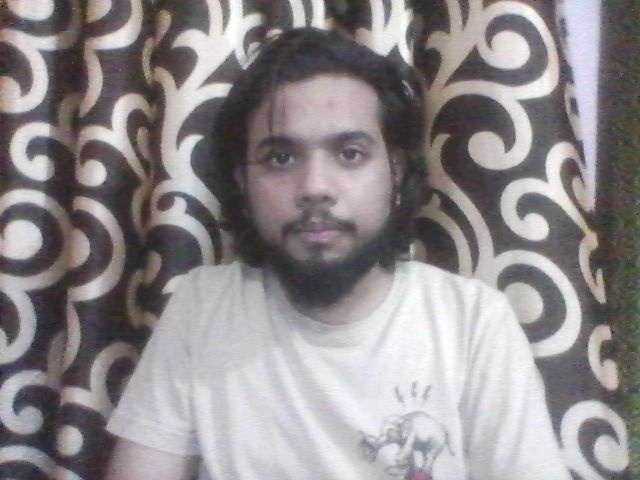

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

[True]


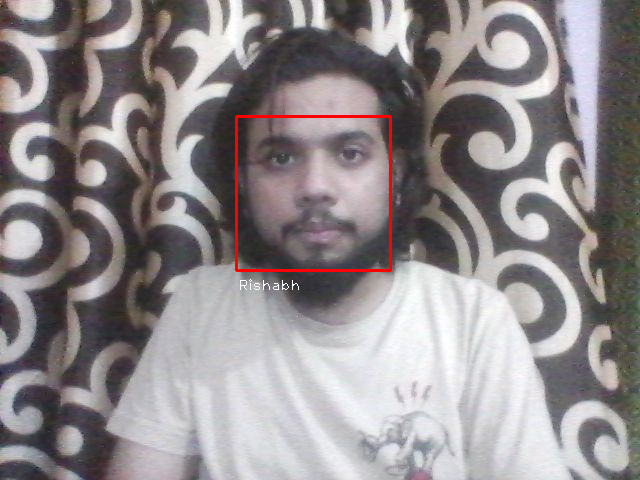

In [ ]:
img = cv2.imread("/content/photo.jpg")
img_enc = face_recognition.face_encodings(img)[0]
results = face_recognition.compare_faces(known_encodings, img_enc)
    # print(face_recognition.face_distance(known_encodings, img_enc))
print(results)

for i in range(len(results)):
    if results[i]:
        name = known_names[i]
        (top, right, bottom, left) = face_recognition.face_locations(img)[0]
        cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 255), 2)
        cv2.putText(img, name, (left+2, bottom+20), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)
        cv2_imshow(img)